# Exploratory Data Analysis

Exploratory data analysis of Bixi 2021 open data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from shapely.geometry import box, Point
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import scipy.stats as ss

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
data_folder = '../input/bixi-open-data-2021/'
stations_file = '2021_stations.csv'
data_file = '2021_donnees_ouvertes.csv'

Two CSV files are available : 
  - 2021_stations.csv contains the name and position data each stations
  - 2021_donnees_ouvertes.csv contains the 5M bike travels.

2021_stations.csv enumerates all the parking stations with their name and position (latitude, longitude). 

In [3]:
df_stations = pd.read_csv(data_folder+stations_file)
df_stations.head()

,pk,name,latitude,longitude
0,10,Métro Angrignon (Lamont / des Trinitaires),45.446910,-73.603630
1,13,Métro de l'Église (Ross / de l'Église),45.462726,-73.565959
2,17,Tolhurst / Fleury,45.544149,-73.667520
3,21,St-Christophe / Cherrier,45.520290,-73.568119
4,31,Lespérance / de Rouen,45.538839,-73.552779


2021_donnees_ouverte.csv shows approximately 5.5 million bike displacements. It gives for each displacement the index of the starting and ending parking station, the duration of the displacement in seconds and if the displacement was done by someone with a member status or not.

In [4]:
df_data = pd.read_csv(data_folder+data_file)
df_data

,start_date,emplacement_pk_start,end_date,emplacement_pk_end,duration_sec,is_member
0,2021-05-21 17:21:44.934,10,2021-05-21 18:07:58.699,10,2773,1
1,2021-06-12 14:45:02.959,10,2021-06-12 15:11:14.937,187,1571,0
2,2021-08-27 08:19:17.396,10,2021-08-27 08:29:04.477,506,587,1
3,2021-06-11 19:07:28.724,10,2021-06-11 19:50:30.214,10,2581,0
4,2021-05-25 07:19:29.669,10,2021-05-25 07:47:42.001,423,1692,1
...,...,...,...,...,...,...
5490038,2021-11-11 14:55:04.039,1140,2021-11-11 14:59:41.446,1140,277,0
5490039,2021-11-13 16:56:22.412,1140,2021-11-13 17:28:59.982,1140,1957,1
5490040,2021-11-11 18:41:06.111,1140,2021-11-11 18:48:18.115,928,432,1
5490041,2021-11-10 18:17:49.654,1140,2021-11-10 18:24:40.643,928,410,1


The first step is to verify the presence of null values :

In [5]:
df_data.isnull().any()

start_date              False
emplacement_pk_start    False
end_date                False
emplacement_pk_end      False
duration_sec            False
is_member               False
dtype: bool

In [6]:
df_stations.isnull().any()

pk           False
name         False
latitude     False
longitude    False
dtype: bool

No null values were detected. It is now time to start dive into the data !

<AxesSubplot:xlabel='is_member', ylabel='Count'>

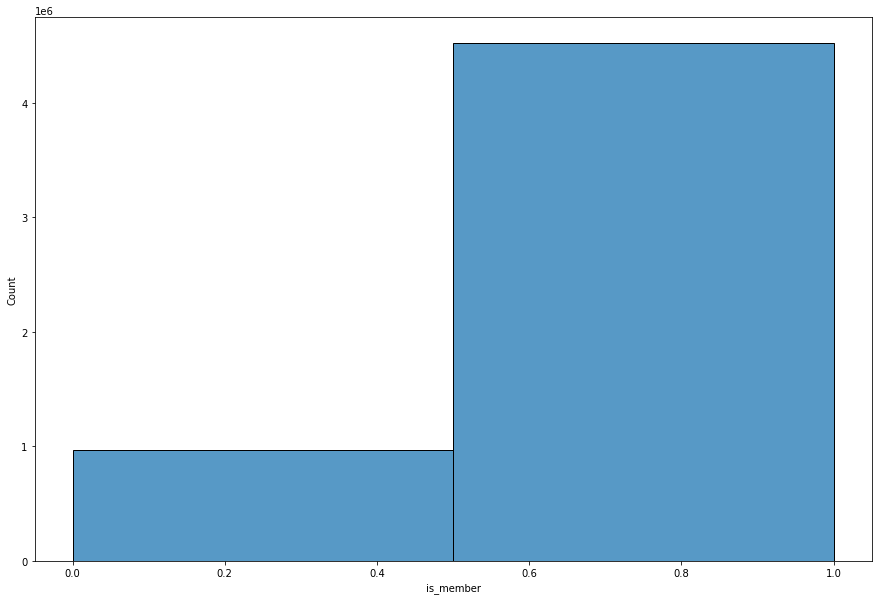

In [7]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='is_member', bins=2)

There are 4 times more members than non-members. If the dataset represents the totality of the displacement for 2021 the bixi service is well adopted by Montreal inhabitants.

## Displacement duration

First as an exploratory data analysis, it is interesting to see the share of displacement done by members and not members in function of the duration of the displacement. 

<AxesSubplot:xlabel='duration_sec', ylabel='Count'>

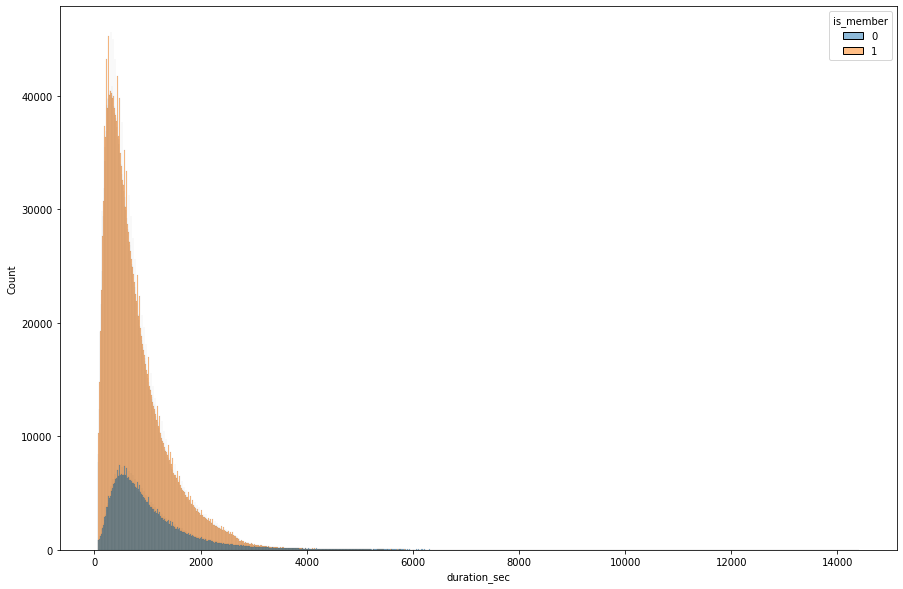

In [8]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='duration_sec', hue='is_member')

<AxesSubplot:xlabel='duration_sec', ylabel='Count'>

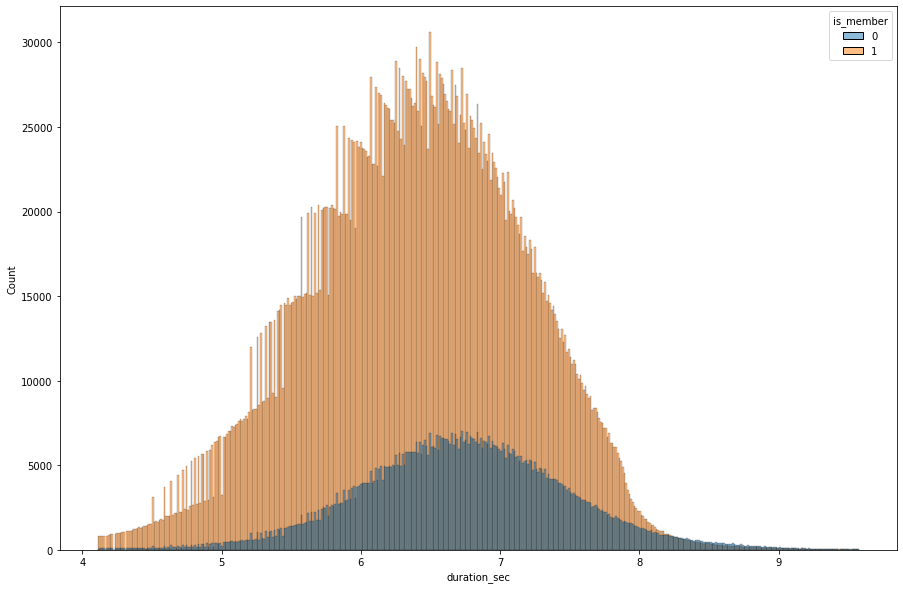

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(x=np.log(df_data['duration_sec']), hue=df_data['is_member'])

Plotting the histogram of the logarithm of the duration gives distributions close to a Gaussian distribution. It means that the duration could be fitted by a lognorm distribution. It is not tackled in this notebook but it is an interesting conclusion of the exploratory data analysis. 

The histogram x-axis is going until 14000 sec (which is equivalent to 4 hours) which seems a very long travel. Let's see how many of these very long trips are present in the data. 

In [10]:
max_duration = df_data['duration_sec'].max()
print(f'The maximum duration is equal to {max_duration} seconds')

The maximum duration is equal to 14397 seconds


In [11]:
very_long_trip = df_data[df_data['duration_sec']>4000]
print(f'Number of displacements longer than 4000 seconds : {very_long_trip["duration_sec"].count()}')

Number of displacements longer than 4000 seconds : 44847


## Parking usage

The distribution of the starting point and finishing point are now explored. 

<AxesSubplot:xlabel='emplacement_pk_start', ylabel='Count'>

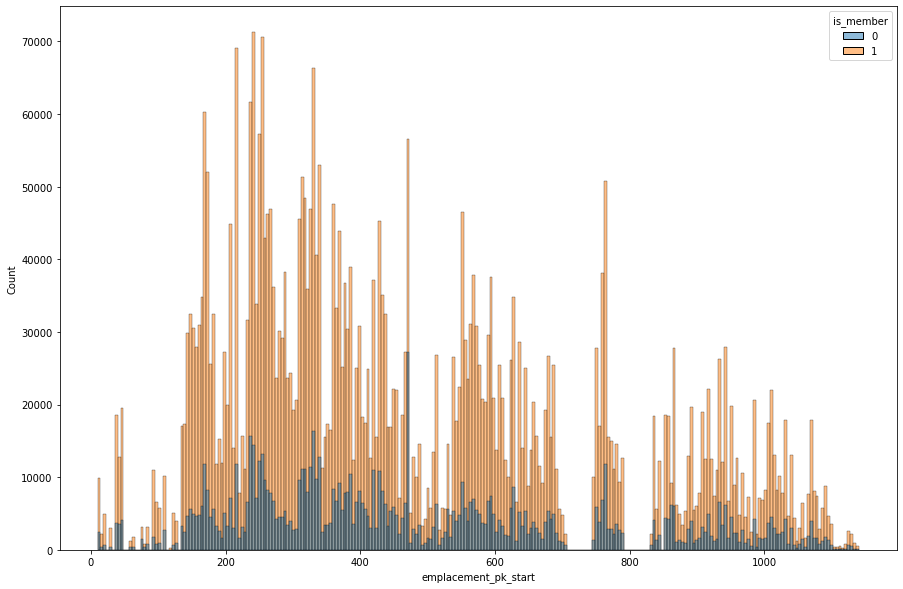

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='emplacement_pk_start', hue='is_member')

<AxesSubplot:xlabel='emplacement_pk_end', ylabel='Count'>

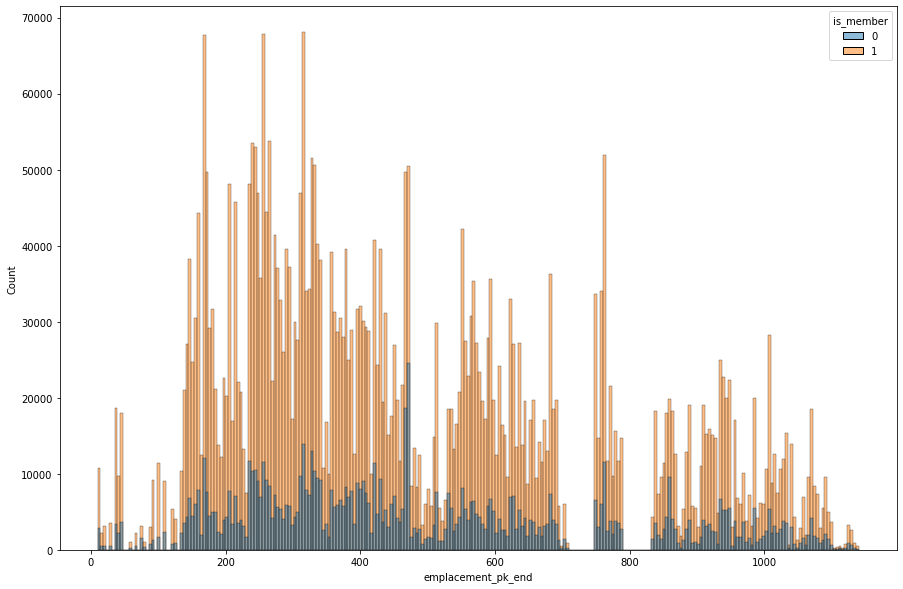

In [13]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='emplacement_pk_end', hue='is_member')

These plots do not give interesting information. 

It should be used with the other .csv files that gives the localization of the parking stations that gives their geolocalizations.

In [14]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [15]:
gdf = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.longitude, df_stations.latitude))

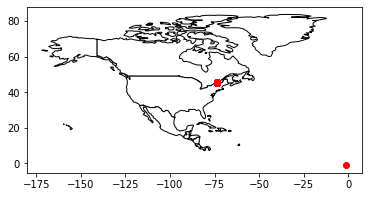

In [16]:
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

We should note that one point is not located in Montreal, it is an error in the database. It can be easily corrected, by finding which stations does not have correct latitude and longitude.

In [17]:
df_stations[df_stations['longitude']>=-5]

,pk,name,latitude,longitude,geometry
570,856,Smith / Peel,-1.0,-1.0,POINT (-1.00000 -1.00000)


The parking station at the angle of Smith st and Peel St. Using google maps it is possible to find its correct longitude and latitude. 

In [18]:
lat, long = 45.49277056666423, -73.5564096881966
df_stations['latitude'] = df_stations['latitude'].replace(to_replace=-1.0, value=lat)
df_stations['longitude'] = df_stations['longitude'].replace(to_replace=-1.0, value=long)
print(df_stations[df_stations['longitude']>=-5])

Empty DataFrame
Columns: [pk, name, latitude, longitude, geometry]
Index: []


It could be interesting to have the utilization of each parking station by counting the number of times of a bike is taken or parked at the station. 

In [19]:
df_start = df_data['emplacement_pk_start'].value_counts()
df_end = df_data['emplacement_pk_end'].value_counts()
df_start.head()
df_end.head()

256    47203
173    35689
470    34669
242    31843
332    31497
Name: emplacement_pk_end, dtype: int64

In [20]:
df_joined = df_stations.join(df_start, on='pk', lsuffix='_caller', rsuffix='_other')
df_joined = df_joined.join(df_end, on='pk', lsuffix='_caller', rsuffix='_other')

df_joined.head()

,pk,name,latitude,longitude,geometry,emplacement_pk_start,emplacement_pk_end
0,10,Métro Angrignon (Lamont / des Trinitaires),45.446910,-73.603630,POINT (-73.60363 45.44691),4398.0,4763
1,13,Métro de l'Église (Ross / de l'Église),45.462726,-73.565959,POINT (-73.56596 45.46273),7988.0,8850
2,17,Tolhurst / Fleury,45.544149,-73.667520,POINT (-73.66752 45.54415),2592.0,2833
3,21,St-Christophe / Cherrier,45.520290,-73.568119,POINT (-73.56812 45.52029),5619.0,3585
4,31,Lespérance / de Rouen,45.538839,-73.552779,POINT (-73.55278 45.53884),3383.0,4059


In [21]:
df_joined['utilisation'] = df_joined['emplacement_pk_start'] + df_joined['emplacement_pk_end']
df_joined

,pk,name,latitude,longitude,geometry,emplacement_pk_start,emplacement_pk_end,utilisation
0,10,Métro Angrignon (Lamont / des Trinitaires),45.446910,-73.603630,POINT (-73.60363 45.44691),4398.0,4763,9161.0
1,13,Métro de l'Église (Ross / de l'Église),45.462726,-73.565959,POINT (-73.56596 45.46273),7988.0,8850,16838.0
2,17,Tolhurst / Fleury,45.544149,-73.667520,POINT (-73.66752 45.54415),2592.0,2833,5425.0
3,21,St-Christophe / Cherrier,45.520290,-73.568119,POINT (-73.56812 45.52029),5619.0,3585,9204.0
4,31,Lespérance / de Rouen,45.538839,-73.552779,POINT (-73.55278 45.53884),3383.0,4059,7442.0
...,...,...,...,...,...,...,...,...
824,1136,Terminus Le Carrefour (Terry-Fox / Le Carrefour),45.568420,-73.746873,POINT (-73.74687 45.56842),1.0,2,3.0
825,1137,Métro Lionel-Groulx (St-Jacques / Atwater),45.483629,-73.579703,POINT (-73.57970 45.48363),159.0,162,321.0
826,1138,Maguire / St-Dominique,45.525267,-73.595237,POINT (-73.59524 45.52527),188.0,183,371.0
827,1139,CHU Ste-Justine (de la Côte Ste-Catherine / Hu...,45.503982,-73.622839,POINT (-73.62284 45.50398),245.0,210,455.0


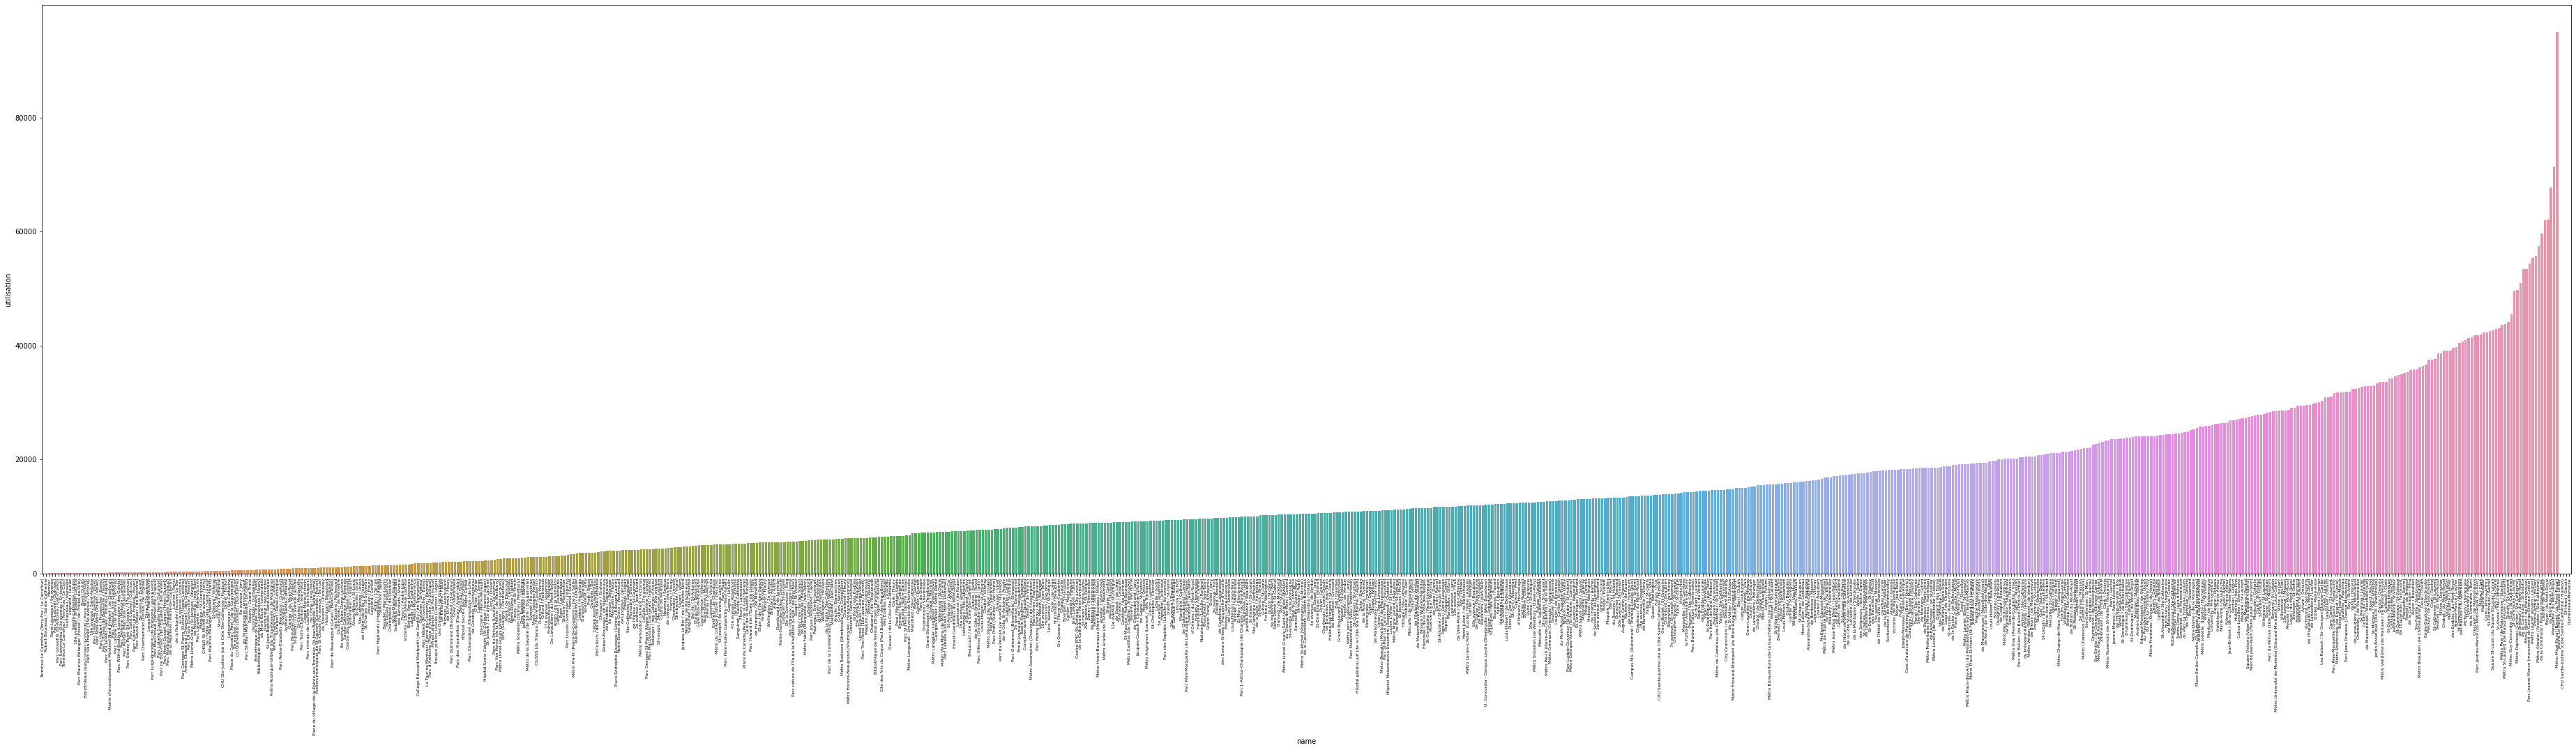

In [22]:
df_plot = df_joined.sort_values(by='utilisation' ).copy()
df_plot[df_plot['utilisation']> 2000.0]

plt.figure(figsize=(65,15))
ax = sns.barplot(data=df_plot[df_plot['utilisation']> 2000.0], y=df_plot['utilisation'], x=df_plot['name'])
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 6})

Here the utilisation with respect to each parking stations is plotted. It is a large figure, depending of the information you are looking for you could plot a reduced amount of information for readibility. 

In [23]:
gdf = gpd.GeoDataFrame(df_joined, geometry=gpd.points_from_xy(df_stations.longitude, df_stations.latitude), crs='EPSG:4326')
#gdf = gpd.GeoDataFrame(Point(df_stations['latitude'].to_numpy(), df_stations['longitude'].to_numpy()), geometry=0, crs="EPSG:3857")

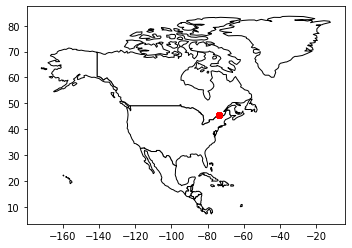

In [24]:
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

Now that we have corrected the data it is possible to plot them on a map.

In [25]:
# Create a map
m_1 = folium.Map(location=[45.513637, -73.582289], tiles='openstreetmap', zoom_start=12)

# Plots every stations on the map can be costly
#for i, row in gdf.iterrows(): 
#    Marker([row['latitude'], row['longitude']]).add_to(m_1)
# Display the map

# Plots clusters of parking stations
# Add points to the map
mc = MarkerCluster()
for idx, row in gdf.iterrows():
    mc.add_child(Marker([row['latitude'], row['longitude']]))
m_1.add_child(mc)
m_1

In [26]:
gdf.sort_values(by='emplacement_pk_start', ascending=False).head()

,pk,name,latitude,longitude,geometry,emplacement_pk_start,emplacement_pk_end,utilisation
136,256,Métro Mont-Royal (Rivard / du Mont-Royal),45.524673,-73.582550,POINT (-73.58255 45.52467),47793.0,47203,94996.0
122,242,du Mont-Royal / Clark,45.519410,-73.586850,POINT (-73.58685 45.51941),35899.0,31843,67742.0
60,173,Marquette / du Mont-Royal,45.532290,-73.575440,POINT (-73.57544 45.53229),35731.0,35689,71420.0
201,330,Parc Jeanne Mance (monument sir George-Etienne...,45.514840,-73.584779,POINT (-73.58478 45.51484),31685.0,22660,54345.0
54,167,Boyer / du Mont-Royal,45.527432,-73.579917,POINT (-73.57992 45.52743),31229.0,30813,62042.0


<AxesSubplot:xlabel='emplacement_pk_start'>

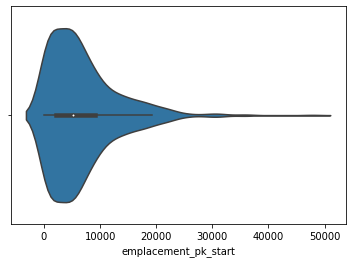

In [27]:
sns.violinplot(data=gdf, x=gdf.emplacement_pk_start)

In [28]:
from matplotlib import cm
# Create a base map
m_4 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)


def color_producer(val):
    if val >= 20000:
        return 'darkred'
    elif val > 10000:
        return 'orange'
    elif val <= 1000:
        return 'green'

# Add a bubble map to the base map
for i in range(len(gdf['emplacement_pk_start'])):
    Circle(
        location=[gdf.iloc[i]['latitude'], 
                  gdf.iloc[i]['longitude']],
        radius=30,
        color=color_producer(gdf.iloc[i]['emplacement_pk_start'])).add_to(m_4)

# Display the map
m_4

In [29]:
# Create a base map
m_5 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)


def color_producer(val):
    if val >= 20000:
        return 'darkred'
    elif val > 10000:
        return 'orange'
    elif val <= 1000:
        return 'green'

# Add a bubble map to the base map
for i in range(len(gdf['emplacement_pk_end'])):
    Circle(
        location=[gdf.iloc[i]['latitude'], 
                  gdf.iloc[i]['longitude']],
        radius=30,
        color=color_producer(gdf.iloc[i]['emplacement_pk_end'])).add_to(m_5)

# Display the map
m_5

In [30]:
from matplotlib import cm
# Create a base map
m_6 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)


def color_producer(val):
    if val >= 20000:
        return 'darkred'
    elif val > 10000:
        return 'orange'
    elif val <= 1000:
        return 'green'

# Add a bubble map to the base map
for i in range(len(gdf['utilisation'])):
    Circle(
        location=[gdf.iloc[i]['latitude'], 
                  gdf.iloc[i]['longitude']],
        radius=30,
        color=color_producer(gdf.iloc[i]['utilisation'])).add_to(m_6)

# Display the map
m_6

What could be useful is to plot the destination of all the bikes taken at one particular station. 

In [31]:
df_data['start_end_pk'] = df_data['emplacement_pk_start'].astype(str) + '-' + df_data['emplacement_pk_end'].astype(str)
df_data.head()

,start_date,emplacement_pk_start,end_date,emplacement_pk_end,duration_sec,is_member,start_end_pk
0,2021-05-21 17:21:44.934,10,2021-05-21 18:07:58.699,10,2773,1,10-10
1,2021-06-12 14:45:02.959,10,2021-06-12 15:11:14.937,187,1571,0,10-187
2,2021-08-27 08:19:17.396,10,2021-08-27 08:29:04.477,506,587,1,10-506
3,2021-06-11 19:07:28.724,10,2021-06-11 19:50:30.214,10,2581,0,10-10
4,2021-05-25 07:19:29.669,10,2021-05-25 07:47:42.001,423,1692,1,10-423


In [32]:
df_travels = df_data['start_end_pk'].value_counts()
df_data = df_data.join(df_travels, on='start_end_pk', lsuffix='_caller', rsuffix='_other')
df_data.head()

,start_date,emplacement_pk_start,end_date,emplacement_pk_end,duration_sec,is_member,start_end_pk_caller,start_end_pk_other
0,2021-05-21 17:21:44.934,10,2021-05-21 18:07:58.699,10,2773,1,10-10,684
1,2021-06-12 14:45:02.959,10,2021-06-12 15:11:14.937,187,1571,0,10-187,37
2,2021-08-27 08:19:17.396,10,2021-08-27 08:29:04.477,506,587,1,10-506,438
3,2021-06-11 19:07:28.724,10,2021-06-11 19:50:30.214,10,2581,0,10-10,684
4,2021-05-25 07:19:29.669,10,2021-05-25 07:47:42.001,423,1692,1,10-423,50


In [33]:
df_start_end = df_data.groupby(['emplacement_pk_start','emplacement_pk_end']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count')
df_start_end

,emplacement_pk_start,emplacement_pk_end,count
86033,314,190,1
244352,782,222,1
244362,782,233,1
244372,782,245,1
89221,321,368,1
...,...,...,...
276506,949,949,1851
151485,469,469,1852
152111,470,470,2362
116337,381,381,2432


In [34]:
def whereto(pk_start):
    '''
    
    '''
    if pk_start in df_stations['pk'].unique():
        # Create a base map
        m_6 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)

        df_tojoin = df_start_end[df_start_end['emplacement_pk_start']==pk_start].rename(columns={'emplacement_pk_end': 'pk'})
        df_where_to = df_tojoin.merge(df_joined, on=['pk', 'pk'], how='left').sort_values(by='count',ascending=False)
        quantile = [df_where_to['count'].quantile(q=0.2), df_where_to['count'].quantile(q=0.9)]
        print(quantile)
        
        def color_producer_interne(val, quantile_8=quantile):
            if val >= quantile[1]:
                return 'darkred'
            elif val <= quantile[0]:
                return 'darkgreen'
            else:
                return 'orange'


        # Add a bubble map to the base map
        for i in range(len(df_where_to['count'])):
            Circle(
                location=[df_where_to.iloc[i]['latitude'], 
                        df_where_to.iloc[i]['longitude']],
                radius=30,
                color=color_producer_interne(df_where_to.iloc[i]['count'])).add_to(m_6)

        start_station = df_stations[df_stations['pk']==pk_start]
        Marker(location=[start_station['latitude'], start_station['longitude']],
               icon=folium.Icon(color='green', icon='circle-arrow-up')).add_to(m_6)
        m_6

    else:
        print('Wrong parking index')
    return m_6

def fromwhere(pk_end):
    '''
    
    '''
    if pk_end in df_stations['pk'].unique():
        # Create a base map
        m_7 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)

        df_tojoin = df_start_end[df_start_end['emplacement_pk_end']==pk_end].rename(columns={'emplacement_pk_start': 'pk'})
        df_from_where = df_tojoin.merge(df_joined, on=['pk', 'pk'], how='left').sort_values(by='count',ascending=False)
        quantile = [df_from_where['count'].quantile(q=0.2), df_from_where['count'].quantile(q=0.9)]
        print(quantile)
        
        def color_producer_interne(val, quantile_8=quantile):
            if val >= quantile[1]:
                return 'darkred'
            elif val <= quantile[0]:
                return 'green'
            else:
                return 'orange'


        # Add a bubble map to the base map
        for i in range(len(df_from_where['count'])):
            Circle(
                location=[df_from_where.iloc[i]['latitude'], 
                        df_from_where.iloc[i]['longitude']],
                radius=30,
                color=color_producer_interne(df_from_where.iloc[i]['count'])).add_to(m_7)

        end_station = df_stations[df_stations['pk']==pk_end]
        Marker(location=[end_station['latitude'], end_station['longitude']],
               icon=folium.Icon(color='red', icon='circle-arrow-down')).add_to(m_7)
        m_7

    else:
        print('Wrong parking index')
    return m_7


It could be useful to see for all the bikes taken at a particular station where they are parked at the end of the trip. In this way you can have a glimpse of the distance traveled depending on the station geolocalization.

In [35]:
whereto(860)

[2.0, 32.900000000000034]


In [36]:
fromwhere(276)

[2.0, 57.30000000000007]


One of the conclusion is that an important number of bikes taken at a given station are returned to the same stations. Which was not intuitive for me at first.